In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

# --- Environment Setup ---y

# Option 1: Using Anaconda
# conda create --name tf python=3.10 anaconda 
# conda activate tf
# pip install -r ../requirements.txt
# Note: This installs an older version of TensorFlow since Anaconda 
# no longer maintains recent GPU packages. It still works reliably.

# Option 2: Using Python venv
# python3 -m venv .venv
# source .venv/bin/activate
# pip install -r ../requirements.txt

from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import utils as np_utils
from fMRINet import fmriNet8, fmriNet16, fmriNet32

import sklearn
import tensorflow as tf

# TensorFlow optimizers

# AdamW lives in different places depending on TF version.
try:
    # TF ≥ 2.13
    from tensorflow.keras.optimizers import AdamW
except ImportError:
    try:
        # TF 2.11–2.12
        from tensorflow.keras.optimizers.experimental import AdamW
    except ImportError:
        # TF 2.10.x (requires tensorflow-addons)
        from tensorflow_addons.optimizers import AdamW

# For compatibility with libraries such as iNNvestigate, 
# you may need to disable eager execution:
# tf.compat.v1.disable_eager_execution()

In [2]:
# Load the DataFrame from the pickle file /-/ this is the toy dataframe ; for the actual data; please consider dataframe.pkl and get in touch with the author.


# #{'PVT': 0, 'VWM': 1, 'DOT': 2, 'MOD': 3, 'DYN': 4, 'rest': 5}
# df = pd.read_pickle('dataframe.pkl')

# df.head()


#{'PVT': 0, 'VWM': 1, 'DOT': 2, 'MOD': 3, 'DYN': 4, 'rest': 5}
df = pd.read_pickle('dataframe.pkl')

df.head()

,Task,Time_Series_Data,subject,session
0,0,"[[1.9457951942054184, 2.1243432446451473, 2.24...",2755j,4
1,0,"[[2.0062126993459035, 1.1112578943817553, 2.87...",2755j,4
3,1,"[[3.1558751679308363, 1.7991844301841418, 2.59...",1043f,3
5,1,"[[1.779440351375669, 1.7387005028929754, 2.338...",4558a,1
7,2,"[[0.11108687476175652, 1.7908513499100132, 0.4...",4662a,8


In [4]:
print("TF version:", tf.__version__)
print("Built with CUDA?", tf.test.is_built_with_cuda())
print("Visible GPUs:", tf.config.list_physical_devices("GPU"))

TF version: 2.19.1
Built with CUDA? False
Visible GPUs: []


In [5]:
# subjs = df["subject"].unique()
# np.random.shuffle(subjs) # do in-place shuffle

# to work with the same train/validation splits while doing model development
with open('subjs.pickle', 'rb') as f:
    subjs = pickle.load(f)

# pull train/valid data by taking subjects from shuffled list
train_df = df[df['subject'].isin(subjs[0:45])]
valid_df = df[df['subject'].isin(subjs[45:,])]

# convert to numpy arrays and do reordering of data dimensions to feed into network
train_label = np.array(train_df['Task'])

train_data  = np.dstack(train_df['Time_Series_Data'])
train_data  = np.expand_dims(train_data, axis=0)
train_data  = np.transpose(train_data, axes=[3, 2, 1, 0]) # (batch, row, time, region)

valid_label = np.array(valid_df['Task'])

valid_data  = np.dstack(valid_df['Time_Series_Data'])
valid_data  = np.expand_dims(valid_data, axis=0)
valid_data  = np.transpose(valid_data, axes=[3, 2, 1, 0]) # (batch, row, time, region)

In [6]:
train_label = np_utils.to_categorical(train_label)
valid_label = np_utils.to_categorical(valid_label)


In [7]:
# calculate class weights for training data to use at training time
train_label_v2 = np.argmax(train_label, axis=1)
a, b           = np.unique(train_label_v2, return_counts=True)
weights        = sklearn.utils.class_weight.compute_class_weight(class_weight='balanced', classes=a, y=train_label_v2)
class_weights  = {0:weights[0], 1:weights[1], 2:weights[2], 3:weights[3], 4:weights[4], 5:weights[5]}
class_weights

{0: np.float64(1.3031135531135531),
 1: np.float64(0.8800247371675943),
 2: np.float64(1.2417102966841187),
 3: np.float64(0.9139370584457289),
 4: np.float64(0.568063872255489),
 5: np.float64(2.2914653784219)}

In [8]:
model = fmriNet8(num_classes=6, input_shape=(214, 277, 1), temporal_kernel_sec=60, fs=1.0)  # or fmriNet16(), fmriNet32()

model.summary()

Model: "fmriNet8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 214, 277, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 214, 277, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 214, 277, 8)    │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute (Permute)               │ (None, 277, 214, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d                │ (None, 277, 1, 32)     │         6,848 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 277, 1, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 277, 1, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute_1 (Permute)             │ (None, 1, 277, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 1, 18, 32)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 18, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 1, 18, 64)      │         2,304 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1, 18, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1, 18, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 1, 4, 64)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         1,542 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Activation)            │ (None, 6)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,558 (45.15 KB)

 Trainable params: 11,366 (44.40 KB)

 Non-trainable params: 192 (768.00 B)

In [9]:
model.compile(loss='categorical_crossentropy', optimizer=AdamW(weight_decay=0.0005), 
              metrics = ['accuracy'])

checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint.h5', verbose=1,
                               save_best_only=True)

# simple learning rate schedule, half learning rate every 200 epochs
# which seems to do ok for this data
def lr_schedule(epoch):
         return (0.001 * np.power(0.5, np.floor(epoch/200)))

scheduler    = LearningRateScheduler(lr_schedule, verbose=1)

In [11]:
# without eager execution this takes much longer to train..
fittedModel = model.fit(train_data, train_label, batch_size = 64, epochs = 400, 
                        verbose = 2, validation_data=(valid_data, valid_label),
                        callbacks=[checkpointer], class_weight = class_weights)

Epoch 1/400

Epoch 1: val_loss improved from 1.79154 to 1.78942, saving model to /tmp/checkpoint.h5


45/45 - 15s - 324ms/step - accuracy: 0.1750 - loss: 1.9266 - val_accuracy: 0.1721 - val_loss: 1.7894
Epoch 2/400

Epoch 2: val_loss improved from 1.78942 to 1.78660, saving model to /tmp/checkpoint.h5


45/45 - 14s - 321ms/step - accuracy: 0.2126 - loss: 1.8779 - val_accuracy: 0.1784 - val_loss: 1.7866
Epoch 3/400

Epoch 3: val_loss improved from 1.78660 to 1.76101, saving model to /tmp/checkpoint.h5


45/45 - 14s - 316ms/step - accuracy: 0.2119 - loss: 1.8369 - val_accuracy: 0.3552 - val_loss: 1.7610
Epoch 4/400

Epoch 4: val_loss improved from 1.76101 to 1.65329, saving model to /tmp/checkpoint.h5


45/45 - 15s - 331ms/step - accuracy: 0.2867 - loss: 1.7037 - val_accuracy: 0.2833 - val_loss: 1.6533
Epoch 5/400

Epoch 5: val_loss improved from 1.65329 to 1.53062, saving model to /tmp/checkpoint.h5


45/45 - 14s - 310ms/step - accuracy: 0.3292 - loss: 1.6028 - val_accuracy: 0.3662 - val_loss: 1.5306
Epoch 6/400

Epoch 6: val_loss improved from 1.53062 to 1.42990, saving model to /tmp/checkpoint.h5


45/45 - 16s - 350ms/step - accuracy: 0.3739 - loss: 1.5147 - val_accuracy: 0.4554 - val_loss: 1.4299
Epoch 7/400

Epoch 7: val_loss improved from 1.42990 to 1.33524, saving model to /tmp/checkpoint.h5


45/45 - 14s - 315ms/step - accuracy: 0.3932 - loss: 1.4314 - val_accuracy: 0.5415 - val_loss: 1.3352
Epoch 8/400

Epoch 8: val_loss improved from 1.33524 to 1.26212, saving model to /tmp/checkpoint.h5


45/45 - 14s - 305ms/step - accuracy: 0.4368 - loss: 1.3654 - val_accuracy: 0.5274 - val_loss: 1.2621
Epoch 9/400

Epoch 9: val_loss improved from 1.26212 to 1.18562, saving model to /tmp/checkpoint.h5


45/45 - 14s - 308ms/step - accuracy: 0.4406 - loss: 1.3221 - val_accuracy: 0.5728 - val_loss: 1.1856
Epoch 10/400

Epoch 10: val_loss improved from 1.18562 to 1.14786, saving model to /tmp/checkpoint.h5


45/45 - 14s - 304ms/step - accuracy: 0.4680 - loss: 1.2588 - val_accuracy: 0.5696 - val_loss: 1.1479
Epoch 11/400

Epoch 11: val_loss improved from 1.14786 to 1.10651, saving model to /tmp/checkpoint.h5


45/45 - 14s - 308ms/step - accuracy: 0.4656 - loss: 1.2733 - val_accuracy: 0.5915 - val_loss: 1.1065
Epoch 12/400

Epoch 12: val_loss improved from 1.10651 to 1.07769, saving model to /tmp/checkpoint.h5


45/45 - 14s - 311ms/step - accuracy: 0.4828 - loss: 1.2130 - val_accuracy: 0.5962 - val_loss: 1.0777
Epoch 13/400

Epoch 13: val_loss improved from 1.07769 to 1.04872, saving model to /tmp/checkpoint.h5


45/45 - 14s - 302ms/step - accuracy: 0.5053 - loss: 1.1965 - val_accuracy: 0.6072 - val_loss: 1.0487
Epoch 14/400

Epoch 14: val_loss improved from 1.04872 to 1.01531, saving model to /tmp/checkpoint.h5


45/45 - 14s - 311ms/step - accuracy: 0.5148 - loss: 1.1610 - val_accuracy: 0.6072 - val_loss: 1.0153
Epoch 15/400

Epoch 15: val_loss improved from 1.01531 to 0.99721, saving model to /tmp/checkpoint.h5


45/45 - 14s - 301ms/step - accuracy: 0.5313 - loss: 1.1226 - val_accuracy: 0.6119 - val_loss: 0.9972
Epoch 16/400

Epoch 16: val_loss did not improve from 0.99721
45/45 - 14s - 304ms/step - accuracy: 0.5422 - loss: 1.0954 - val_accuracy: 0.5837 - val_loss: 1.0285
Epoch 17/400

Epoch 17: val_loss improved from 0.99721 to 0.94045, saving model to /tmp/checkpoint.h5


45/45 - 14s - 304ms/step - accuracy: 0.5527 - loss: 1.0726 - val_accuracy: 0.6416 - val_loss: 0.9404
Epoch 18/400

Epoch 18: val_loss improved from 0.94045 to 0.91370, saving model to /tmp/checkpoint.h5


45/45 - 14s - 303ms/step - accuracy: 0.5597 - loss: 1.0527 - val_accuracy: 0.6620 - val_loss: 0.9137
Epoch 19/400

Epoch 19: val_loss improved from 0.91370 to 0.85128, saving model to /tmp/checkpoint.h5


45/45 - 14s - 304ms/step - accuracy: 0.5587 - loss: 1.0354 - val_accuracy: 0.7167 - val_loss: 0.8513
Epoch 20/400

Epoch 20: val_loss did not improve from 0.85128
45/45 - 14s - 301ms/step - accuracy: 0.5703 - loss: 1.0281 - val_accuracy: 0.7105 - val_loss: 0.8559
Epoch 21/400

Epoch 21: val_loss did not improve from 0.85128
45/45 - 14s - 304ms/step - accuracy: 0.5833 - loss: 1.0100 - val_accuracy: 0.6839 - val_loss: 0.8690
Epoch 22/400

Epoch 22: val_loss did not improve from 0.85128
45/45 - 14s - 305ms/step - accuracy: 0.5875 - loss: 0.9717 - val_accuracy: 0.6995 - val_loss: 0.8553
Epoch 23/400

Epoch 23: val_loss improved from 0.85128 to 0.83282, saving model to /tmp/checkpoint.h5


45/45 - 14s - 302ms/step - accuracy: 0.5945 - loss: 0.9845 - val_accuracy: 0.7074 - val_loss: 0.8328
Epoch 24/400

Epoch 24: val_loss improved from 0.83282 to 0.79037, saving model to /tmp/checkpoint.h5


45/45 - 14s - 309ms/step - accuracy: 0.5973 - loss: 0.9380 - val_accuracy: 0.7449 - val_loss: 0.7904
Epoch 25/400

Epoch 25: val_loss did not improve from 0.79037
45/45 - 14s - 310ms/step - accuracy: 0.6044 - loss: 0.9654 - val_accuracy: 0.7074 - val_loss: 0.8107
Epoch 26/400

Epoch 26: val_loss did not improve from 0.79037
45/45 - 14s - 311ms/step - accuracy: 0.6160 - loss: 0.9272 - val_accuracy: 0.7089 - val_loss: 0.8063
Epoch 27/400

Epoch 27: val_loss improved from 0.79037 to 0.78774, saving model to /tmp/checkpoint.h5


45/45 - 14s - 304ms/step - accuracy: 0.5963 - loss: 0.9206 - val_accuracy: 0.7308 - val_loss: 0.7877
Epoch 28/400

Epoch 28: val_loss improved from 0.78774 to 0.77334, saving model to /tmp/checkpoint.h5


45/45 - 14s - 305ms/step - accuracy: 0.6233 - loss: 0.8853 - val_accuracy: 0.7559 - val_loss: 0.7733
Epoch 29/400

Epoch 29: val_loss improved from 0.77334 to 0.76953, saving model to /tmp/checkpoint.h5


45/45 - 14s - 302ms/step - accuracy: 0.6395 - loss: 0.8974 - val_accuracy: 0.7559 - val_loss: 0.7695
Epoch 30/400

Epoch 30: val_loss improved from 0.76953 to 0.76149, saving model to /tmp/checkpoint.h5


45/45 - 13s - 297ms/step - accuracy: 0.6230 - loss: 0.9063 - val_accuracy: 0.7527 - val_loss: 0.7615
Epoch 31/400

Epoch 31: val_loss improved from 0.76149 to 0.74397, saving model to /tmp/checkpoint.h5


45/45 - 14s - 309ms/step - accuracy: 0.6283 - loss: 0.8883 - val_accuracy: 0.7621 - val_loss: 0.7440
Epoch 32/400

Epoch 32: val_loss improved from 0.74397 to 0.74144, saving model to /tmp/checkpoint.h5


45/45 - 14s - 310ms/step - accuracy: 0.6381 - loss: 0.8749 - val_accuracy: 0.7700 - val_loss: 0.7414
Epoch 33/400

Epoch 33: val_loss improved from 0.74144 to 0.72977, saving model to /tmp/checkpoint.h5


45/45 - 14s - 302ms/step - accuracy: 0.6314 - loss: 0.8740 - val_accuracy: 0.7621 - val_loss: 0.7298
Epoch 34/400

Epoch 34: val_loss improved from 0.72977 to 0.71361, saving model to /tmp/checkpoint.h5


45/45 - 13s - 298ms/step - accuracy: 0.6451 - loss: 0.8604 - val_accuracy: 0.7825 - val_loss: 0.7136
Epoch 35/400

Epoch 35: val_loss did not improve from 0.71361
45/45 - 13s - 298ms/step - accuracy: 0.6486 - loss: 0.8558 - val_accuracy: 0.7715 - val_loss: 0.7250
Epoch 36/400

Epoch 36: val_loss improved from 0.71361 to 0.70817, saving model to /tmp/checkpoint.h5


45/45 - 15s - 325ms/step - accuracy: 0.6514 - loss: 0.8533 - val_accuracy: 0.7966 - val_loss: 0.7082
Epoch 37/400

Epoch 37: val_loss did not improve from 0.70817
45/45 - 15s - 323ms/step - accuracy: 0.6585 - loss: 0.8438 - val_accuracy: 0.7840 - val_loss: 0.7085
Epoch 38/400

Epoch 38: val_loss did not improve from 0.70817
45/45 - 14s - 320ms/step - accuracy: 0.6557 - loss: 0.8428 - val_accuracy: 0.7715 - val_loss: 0.7154
Epoch 39/400

Epoch 39: val_loss improved from 0.70817 to 0.70309, saving model to /tmp/checkpoint.h5


45/45 - 15s - 325ms/step - accuracy: 0.6595 - loss: 0.8325 - val_accuracy: 0.8075 - val_loss: 0.7031
Epoch 40/400

Epoch 40: val_loss did not improve from 0.70309
45/45 - 14s - 319ms/step - accuracy: 0.6609 - loss: 0.8289 - val_accuracy: 0.7621 - val_loss: 0.7212
Epoch 41/400

Epoch 41: val_loss improved from 0.70309 to 0.69138, saving model to /tmp/checkpoint.h5


45/45 - 15s - 326ms/step - accuracy: 0.6725 - loss: 0.8383 - val_accuracy: 0.7793 - val_loss: 0.6914
Epoch 42/400

Epoch 42: val_loss improved from 0.69138 to 0.67891, saving model to /tmp/checkpoint.h5


45/45 - 14s - 321ms/step - accuracy: 0.6718 - loss: 0.8051 - val_accuracy: 0.7934 - val_loss: 0.6789
Epoch 43/400

Epoch 43: val_loss improved from 0.67891 to 0.67327, saving model to /tmp/checkpoint.h5


45/45 - 15s - 325ms/step - accuracy: 0.6711 - loss: 0.8013 - val_accuracy: 0.7950 - val_loss: 0.6733
Epoch 44/400

Epoch 44: val_loss did not improve from 0.67327
45/45 - 15s - 324ms/step - accuracy: 0.6760 - loss: 0.8010 - val_accuracy: 0.7684 - val_loss: 0.7073
Epoch 45/400

Epoch 45: val_loss did not improve from 0.67327
45/45 - 15s - 324ms/step - accuracy: 0.6753 - loss: 0.7959 - val_accuracy: 0.7856 - val_loss: 0.6756
Epoch 46/400

Epoch 46: val_loss improved from 0.67327 to 0.66598, saving model to /tmp/checkpoint.h5


45/45 - 15s - 328ms/step - accuracy: 0.6764 - loss: 0.7741 - val_accuracy: 0.7950 - val_loss: 0.6660
Epoch 47/400

Epoch 47: val_loss did not improve from 0.66598
45/45 - 14s - 319ms/step - accuracy: 0.6929 - loss: 0.7724 - val_accuracy: 0.7934 - val_loss: 0.6715
Epoch 48/400

Epoch 48: val_loss did not improve from 0.66598
45/45 - 15s - 323ms/step - accuracy: 0.6739 - loss: 0.8099 - val_accuracy: 0.7934 - val_loss: 0.6712
Epoch 49/400

Epoch 49: val_loss did not improve from 0.66598
45/45 - 14s - 320ms/step - accuracy: 0.6918 - loss: 0.7607 - val_accuracy: 0.7793 - val_loss: 0.6757
Epoch 50/400

Epoch 50: val_loss improved from 0.66598 to 0.66241, saving model to /tmp/checkpoint.h5


45/45 - 14s - 321ms/step - accuracy: 0.6817 - loss: 0.7935 - val_accuracy: 0.8059 - val_loss: 0.6624
Epoch 51/400

Epoch 51: val_loss did not improve from 0.66241
45/45 - 14s - 322ms/step - accuracy: 0.6873 - loss: 0.8001 - val_accuracy: 0.7856 - val_loss: 0.6738
Epoch 52/400

Epoch 52: val_loss did not improve from 0.66241
45/45 - 14s - 317ms/step - accuracy: 0.6831 - loss: 0.7951 - val_accuracy: 0.7731 - val_loss: 0.6801
Epoch 53/400

Epoch 53: val_loss did not improve from 0.66241
45/45 - 14s - 321ms/step - accuracy: 0.6940 - loss: 0.7696 - val_accuracy: 0.7762 - val_loss: 0.6757
Epoch 54/400

Epoch 54: val_loss did not improve from 0.66241
45/45 - 14s - 320ms/step - accuracy: 0.6954 - loss: 0.7592 - val_accuracy: 0.7919 - val_loss: 0.6716
Epoch 55/400

Epoch 55: val_loss improved from 0.66241 to 0.64717, saving model to /tmp/checkpoint.h5


45/45 - 15s - 323ms/step - accuracy: 0.6996 - loss: 0.7488 - val_accuracy: 0.8028 - val_loss: 0.6472
Epoch 56/400

Epoch 56: val_loss did not improve from 0.64717
45/45 - 14s - 321ms/step - accuracy: 0.7006 - loss: 0.7488 - val_accuracy: 0.7903 - val_loss: 0.6629
Epoch 57/400

Epoch 57: val_loss improved from 0.64717 to 0.64234, saving model to /tmp/checkpoint.h5


45/45 - 14s - 317ms/step - accuracy: 0.6968 - loss: 0.7565 - val_accuracy: 0.7981 - val_loss: 0.6423
Epoch 58/400

Epoch 58: val_loss did not improve from 0.64234
45/45 - 14s - 321ms/step - accuracy: 0.6911 - loss: 0.7596 - val_accuracy: 0.7903 - val_loss: 0.6495
Epoch 59/400

Epoch 59: val_loss did not improve from 0.64234
45/45 - 15s - 331ms/step - accuracy: 0.7129 - loss: 0.7507 - val_accuracy: 0.7872 - val_loss: 0.6643
Epoch 60/400

Epoch 60: val_loss did not improve from 0.64234
45/45 - 14s - 321ms/step - accuracy: 0.7091 - loss: 0.7643 - val_accuracy: 0.7731 - val_loss: 0.6718
Epoch 61/400

Epoch 61: val_loss did not improve from 0.64234
45/45 - 14s - 322ms/step - accuracy: 0.7073 - loss: 0.7576 - val_accuracy: 0.7919 - val_loss: 0.6577
Epoch 62/400

Epoch 62: val_loss did not improve from 0.64234
45/45 - 15s - 323ms/step - accuracy: 0.6950 - loss: 0.7751 - val_accuracy: 0.8044 - val_loss: 0.6466
Epoch 63/400

Epoch 63: val_loss did not improve from 0.64234
45/45 - 14s - 322ms/st

45/45 - 14s - 319ms/step - accuracy: 0.7217 - loss: 0.7165 - val_accuracy: 0.8013 - val_loss: 0.6311
Epoch 67/400

Epoch 67: val_loss improved from 0.63111 to 0.61353, saving model to /tmp/checkpoint.h5


45/45 - 15s - 323ms/step - accuracy: 0.7098 - loss: 0.7436 - val_accuracy: 0.8106 - val_loss: 0.6135
Epoch 68/400

Epoch 68: val_loss did not improve from 0.61353
45/45 - 15s - 327ms/step - accuracy: 0.6985 - loss: 0.7215 - val_accuracy: 0.7950 - val_loss: 0.6487
Epoch 69/400

Epoch 69: val_loss did not improve from 0.61353
45/45 - 15s - 325ms/step - accuracy: 0.7242 - loss: 0.7063 - val_accuracy: 0.8075 - val_loss: 0.6240
Epoch 70/400

Epoch 70: val_loss did not improve from 0.61353
45/45 - 14s - 322ms/step - accuracy: 0.7312 - loss: 0.6975 - val_accuracy: 0.7950 - val_loss: 0.6405
Epoch 71/400

Epoch 71: val_loss did not improve from 0.61353
45/45 - 15s - 325ms/step - accuracy: 0.7217 - loss: 0.7077 - val_accuracy: 0.7840 - val_loss: 0.6444
Epoch 72/400

Epoch 72: val_loss did not improve from 0.61353
45/45 - 15s - 323ms/step - accuracy: 0.7171 - loss: 0.7094 - val_accuracy: 0.7950 - val_loss: 0.6349
Epoch 73/400

Epoch 73: val_loss did not improve from 0.61353
45/45 - 15s - 324ms/st

45/45 - 15s - 327ms/step - accuracy: 0.7164 - loss: 0.7038 - val_accuracy: 0.8059 - val_loss: 0.6075
Epoch 75/400

Epoch 75: val_loss did not improve from 0.60748
45/45 - 15s - 323ms/step - accuracy: 0.7063 - loss: 0.7426 - val_accuracy: 0.8091 - val_loss: 0.6105
Epoch 76/400

Epoch 76: val_loss did not improve from 0.60748
45/45 - 14s - 322ms/step - accuracy: 0.7407 - loss: 0.7065 - val_accuracy: 0.8044 - val_loss: 0.6289
Epoch 77/400

Epoch 77: val_loss did not improve from 0.60748
45/45 - 14s - 316ms/step - accuracy: 0.7182 - loss: 0.7269 - val_accuracy: 0.8106 - val_loss: 0.6198
Epoch 78/400

Epoch 78: val_loss did not improve from 0.60748
45/45 - 14s - 316ms/step - accuracy: 0.7280 - loss: 0.7126 - val_accuracy: 0.7825 - val_loss: 0.6424
Epoch 79/400

Epoch 79: val_loss did not improve from 0.60748
45/45 - 15s - 322ms/step - accuracy: 0.7140 - loss: 0.7229 - val_accuracy: 0.8059 - val_loss: 0.6249
Epoch 80/400

Epoch 80: val_loss did not improve from 0.60748
45/45 - 15s - 325ms/st

45/45 - 14s - 320ms/step - accuracy: 0.7344 - loss: 0.7002 - val_accuracy: 0.8138 - val_loss: 0.6028
Epoch 104/400

Epoch 104: val_loss did not improve from 0.60282
45/45 - 15s - 324ms/step - accuracy: 0.7231 - loss: 0.6900 - val_accuracy: 0.8028 - val_loss: 0.6098
Epoch 105/400

Epoch 105: val_loss did not improve from 0.60282
45/45 - 14s - 322ms/step - accuracy: 0.7224 - loss: 0.7136 - val_accuracy: 0.8138 - val_loss: 0.6213
Epoch 106/400

Epoch 106: val_loss did not improve from 0.60282
45/45 - 14s - 320ms/step - accuracy: 0.7287 - loss: 0.7150 - val_accuracy: 0.7903 - val_loss: 0.6465
Epoch 107/400

Epoch 107: val_loss did not improve from 0.60282
45/45 - 15s - 324ms/step - accuracy: 0.7323 - loss: 0.6791 - val_accuracy: 0.7887 - val_loss: 0.6399
Epoch 108/400

Epoch 108: val_loss did not improve from 0.60282
45/45 - 15s - 326ms/step - accuracy: 0.7337 - loss: 0.6930 - val_accuracy: 0.8059 - val_loss: 0.6251
Epoch 109/400

Epoch 109: val_loss did not improve from 0.60282
45/45 - 14

45/45 - 13s - 295ms/step - accuracy: 0.7372 - loss: 0.6892 - val_accuracy: 0.8091 - val_loss: 0.6018
Epoch 127/400

Epoch 127: val_loss did not improve from 0.60178
45/45 - 13s - 294ms/step - accuracy: 0.7330 - loss: 0.7127 - val_accuracy: 0.8138 - val_loss: 0.6120
Epoch 128/400

Epoch 128: val_loss did not improve from 0.60178
45/45 - 13s - 293ms/step - accuracy: 0.7446 - loss: 0.6754 - val_accuracy: 0.7997 - val_loss: 0.6307
Epoch 129/400

Epoch 129: val_loss did not improve from 0.60178
45/45 - 13s - 291ms/step - accuracy: 0.7319 - loss: 0.6971 - val_accuracy: 0.8185 - val_loss: 0.6087
Epoch 130/400

Epoch 130: val_loss did not improve from 0.60178
45/45 - 13s - 293ms/step - accuracy: 0.7301 - loss: 0.6826 - val_accuracy: 0.8153 - val_loss: 0.6146
Epoch 131/400

Epoch 131: val_loss did not improve from 0.60178
45/45 - 13s - 290ms/step - accuracy: 0.7474 - loss: 0.6604 - val_accuracy: 0.8075 - val_loss: 0.6176
Epoch 132/400

Epoch 132: val_loss did not improve from 0.60178
45/45 - 13

45/45 - 13s - 295ms/step - accuracy: 0.7252 - loss: 0.6888 - val_accuracy: 0.8185 - val_loss: 0.5991
Epoch 137/400

Epoch 137: val_loss did not improve from 0.59912
45/45 - 13s - 294ms/step - accuracy: 0.7340 - loss: 0.6640 - val_accuracy: 0.8044 - val_loss: 0.6172
Epoch 138/400

Epoch 138: val_loss did not improve from 0.59912
45/45 - 13s - 291ms/step - accuracy: 0.7351 - loss: 0.6834 - val_accuracy: 0.8169 - val_loss: 0.6053
Epoch 139/400

Epoch 139: val_loss did not improve from 0.59912
45/45 - 13s - 295ms/step - accuracy: 0.7453 - loss: 0.6508 - val_accuracy: 0.7981 - val_loss: 0.6209
Epoch 140/400

Epoch 140: val_loss did not improve from 0.59912
45/45 - 13s - 289ms/step - accuracy: 0.7386 - loss: 0.6725 - val_accuracy: 0.8106 - val_loss: 0.6048
Epoch 141/400

Epoch 141: val_loss did not improve from 0.59912
45/45 - 13s - 294ms/step - accuracy: 0.7393 - loss: 0.6823 - val_accuracy: 0.8091 - val_loss: 0.5998
Epoch 142/400

Epoch 142: val_loss did not improve from 0.59912
45/45 - 13

45/45 - 13s - 291ms/step - accuracy: 0.7389 - loss: 0.6630 - val_accuracy: 0.8200 - val_loss: 0.5937
Epoch 145/400

Epoch 145: val_loss did not improve from 0.59369
45/45 - 13s - 287ms/step - accuracy: 0.7333 - loss: 0.6806 - val_accuracy: 0.7950 - val_loss: 0.6132
Epoch 146/400

Epoch 146: val_loss did not improve from 0.59369
45/45 - 13s - 294ms/step - accuracy: 0.7351 - loss: 0.6717 - val_accuracy: 0.8122 - val_loss: 0.6082
Epoch 147/400

Epoch 147: val_loss did not improve from 0.59369
45/45 - 13s - 293ms/step - accuracy: 0.7396 - loss: 0.6934 - val_accuracy: 0.7997 - val_loss: 0.6026
Epoch 148/400

Epoch 148: val_loss did not improve from 0.59369
45/45 - 13s - 291ms/step - accuracy: 0.7351 - loss: 0.6654 - val_accuracy: 0.8075 - val_loss: 0.5981
Epoch 149/400

Epoch 149: val_loss did not improve from 0.59369
45/45 - 13s - 293ms/step - accuracy: 0.7340 - loss: 0.6712 - val_accuracy: 0.7934 - val_loss: 0.6019
Epoch 150/400

Epoch 150: val_loss did not improve from 0.59369
45/45 - 13

45/45 - 13s - 293ms/step - accuracy: 0.7407 - loss: 0.6688 - val_accuracy: 0.8232 - val_loss: 0.5920
Epoch 152/400

Epoch 152: val_loss did not improve from 0.59197
45/45 - 13s - 288ms/step - accuracy: 0.7305 - loss: 0.6762 - val_accuracy: 0.8059 - val_loss: 0.6111
Epoch 153/400

Epoch 153: val_loss did not improve from 0.59197
45/45 - 13s - 290ms/step - accuracy: 0.7242 - loss: 0.6707 - val_accuracy: 0.7966 - val_loss: 0.6050
Epoch 154/400

Epoch 154: val_loss improved from 0.59197 to 0.59150, saving model to /tmp/checkpoint.h5


45/45 - 13s - 288ms/step - accuracy: 0.7428 - loss: 0.6645 - val_accuracy: 0.8200 - val_loss: 0.5915
Epoch 155/400

Epoch 155: val_loss did not improve from 0.59150
45/45 - 13s - 295ms/step - accuracy: 0.7259 - loss: 0.6711 - val_accuracy: 0.8091 - val_loss: 0.6109
Epoch 156/400

Epoch 156: val_loss did not improve from 0.59150
45/45 - 13s - 294ms/step - accuracy: 0.7393 - loss: 0.6585 - val_accuracy: 0.8169 - val_loss: 0.6031
Epoch 157/400

Epoch 157: val_loss did not improve from 0.59150
45/45 - 13s - 288ms/step - accuracy: 0.7453 - loss: 0.6670 - val_accuracy: 0.8075 - val_loss: 0.6065
Epoch 158/400

Epoch 158: val_loss did not improve from 0.59150
45/45 - 13s - 291ms/step - accuracy: 0.7368 - loss: 0.6726 - val_accuracy: 0.8091 - val_loss: 0.6060
Epoch 159/400

Epoch 159: val_loss did not improve from 0.59150
45/45 - 13s - 295ms/step - accuracy: 0.7519 - loss: 0.6545 - val_accuracy: 0.8059 - val_loss: 0.6008
Epoch 160/400

Epoch 160: val_loss did not improve from 0.59150
45/45 - 13

45/45 - 14s - 306ms/step - accuracy: 0.7579 - loss: 0.6422 - val_accuracy: 0.8185 - val_loss: 0.5870
Epoch 179/400

Epoch 179: val_loss did not improve from 0.58698
45/45 - 14s - 307ms/step - accuracy: 0.7439 - loss: 0.6289 - val_accuracy: 0.8200 - val_loss: 0.5947
Epoch 180/400

Epoch 180: val_loss did not improve from 0.58698
45/45 - 14s - 304ms/step - accuracy: 0.7526 - loss: 0.6287 - val_accuracy: 0.8044 - val_loss: 0.6124
Epoch 181/400

Epoch 181: val_loss did not improve from 0.58698
45/45 - 14s - 308ms/step - accuracy: 0.7428 - loss: 0.6688 - val_accuracy: 0.8075 - val_loss: 0.6109
Epoch 182/400

Epoch 182: val_loss did not improve from 0.58698
45/45 - 14s - 304ms/step - accuracy: 0.7298 - loss: 0.6741 - val_accuracy: 0.8122 - val_loss: 0.6113
Epoch 183/400

Epoch 183: val_loss did not improve from 0.58698
45/45 - 14s - 305ms/step - accuracy: 0.7389 - loss: 0.6973 - val_accuracy: 0.8091 - val_loss: 0.6133
Epoch 184/400

Epoch 184: val_loss did not improve from 0.58698
45/45 - 14

45/45 - 15s - 325ms/step - accuracy: 0.7590 - loss: 0.6407 - val_accuracy: 0.8200 - val_loss: 0.5840
Epoch 202/400

Epoch 202: val_loss did not improve from 0.58404
45/45 - 15s - 323ms/step - accuracy: 0.7393 - loss: 0.6645 - val_accuracy: 0.8106 - val_loss: 0.6073
Epoch 203/400

Epoch 203: val_loss did not improve from 0.58404
45/45 - 14s - 322ms/step - accuracy: 0.7446 - loss: 0.6564 - val_accuracy: 0.8122 - val_loss: 0.6044
Epoch 204/400

Epoch 204: val_loss did not improve from 0.58404
45/45 - 15s - 324ms/step - accuracy: 0.7446 - loss: 0.6647 - val_accuracy: 0.8122 - val_loss: 0.6061
Epoch 205/400

Epoch 205: val_loss did not improve from 0.58404
45/45 - 15s - 327ms/step - accuracy: 0.7424 - loss: 0.6588 - val_accuracy: 0.8200 - val_loss: 0.6103
Epoch 206/400

Epoch 206: val_loss did not improve from 0.58404
45/45 - 15s - 324ms/step - accuracy: 0.7421 - loss: 0.6643 - val_accuracy: 0.8138 - val_loss: 0.6110
Epoch 207/400

Epoch 207: val_loss did not improve from 0.58404
45/45 - 15

45/45 - 15s - 323ms/step - accuracy: 0.7530 - loss: 0.6452 - val_accuracy: 0.8247 - val_loss: 0.5831
Epoch 226/400

Epoch 226: val_loss did not improve from 0.58311
45/45 - 15s - 327ms/step - accuracy: 0.7439 - loss: 0.6559 - val_accuracy: 0.8138 - val_loss: 0.5956
Epoch 227/400

Epoch 227: val_loss did not improve from 0.58311
45/45 - 15s - 326ms/step - accuracy: 0.7604 - loss: 0.6203 - val_accuracy: 0.8310 - val_loss: 0.5891
Epoch 228/400

Epoch 228: val_loss did not improve from 0.58311
45/45 - 15s - 323ms/step - accuracy: 0.7554 - loss: 0.6281 - val_accuracy: 0.8075 - val_loss: 0.6023
Epoch 229/400

Epoch 229: val_loss did not improve from 0.58311
45/45 - 15s - 322ms/step - accuracy: 0.7456 - loss: 0.6561 - val_accuracy: 0.8200 - val_loss: 0.5895
Epoch 230/400

Epoch 230: val_loss did not improve from 0.58311
45/45 - 15s - 325ms/step - accuracy: 0.7470 - loss: 0.6505 - val_accuracy: 0.8232 - val_loss: 0.5946
Epoch 231/400

Epoch 231: val_loss did not improve from 0.58311
45/45 - 15

45/45 - 14s - 321ms/step - accuracy: 0.7470 - loss: 0.6410 - val_accuracy: 0.8185 - val_loss: 0.5795
Epoch 250/400

Epoch 250: val_loss did not improve from 0.57949
45/45 - 15s - 325ms/step - accuracy: 0.7495 - loss: 0.6602 - val_accuracy: 0.7997 - val_loss: 0.5907
Epoch 251/400

Epoch 251: val_loss did not improve from 0.57949
45/45 - 15s - 328ms/step - accuracy: 0.7358 - loss: 0.6534 - val_accuracy: 0.8059 - val_loss: 0.5992
Epoch 252/400

Epoch 252: val_loss did not improve from 0.57949
45/45 - 15s - 324ms/step - accuracy: 0.7498 - loss: 0.6341 - val_accuracy: 0.8122 - val_loss: 0.5995
Epoch 253/400

Epoch 253: val_loss did not improve from 0.57949
45/45 - 15s - 326ms/step - accuracy: 0.7509 - loss: 0.6471 - val_accuracy: 0.8075 - val_loss: 0.5885
Epoch 254/400

Epoch 254: val_loss did not improve from 0.57949
45/45 - 15s - 327ms/step - accuracy: 0.7463 - loss: 0.6579 - val_accuracy: 0.8059 - val_loss: 0.5908
Epoch 255/400

Epoch 255: val_loss did not improve from 0.57949
45/45 - 15

45/45 - 14s - 303ms/step - accuracy: 0.7572 - loss: 0.6260 - val_accuracy: 0.8388 - val_loss: 0.5668
Epoch 317/400

Epoch 317: val_loss did not improve from 0.56678
45/45 - 13s - 294ms/step - accuracy: 0.7544 - loss: 0.6436 - val_accuracy: 0.8200 - val_loss: 0.5746
Epoch 318/400

Epoch 318: val_loss did not improve from 0.56678
45/45 - 13s - 298ms/step - accuracy: 0.7530 - loss: 0.6358 - val_accuracy: 0.8294 - val_loss: 0.5967
Epoch 319/400

Epoch 319: val_loss did not improve from 0.56678
45/45 - 13s - 296ms/step - accuracy: 0.7439 - loss: 0.6598 - val_accuracy: 0.8232 - val_loss: 0.5939
Epoch 320/400

Epoch 320: val_loss did not improve from 0.56678
45/45 - 13s - 294ms/step - accuracy: 0.7540 - loss: 0.6258 - val_accuracy: 0.8326 - val_loss: 0.5840
Epoch 321/400

Epoch 321: val_loss did not improve from 0.56678
45/45 - 15s - 324ms/step - accuracy: 0.7396 - loss: 0.6401 - val_accuracy: 0.8263 - val_loss: 0.5927
Epoch 322/400

Epoch 322: val_loss did not improve from 0.56678
45/45 - 15

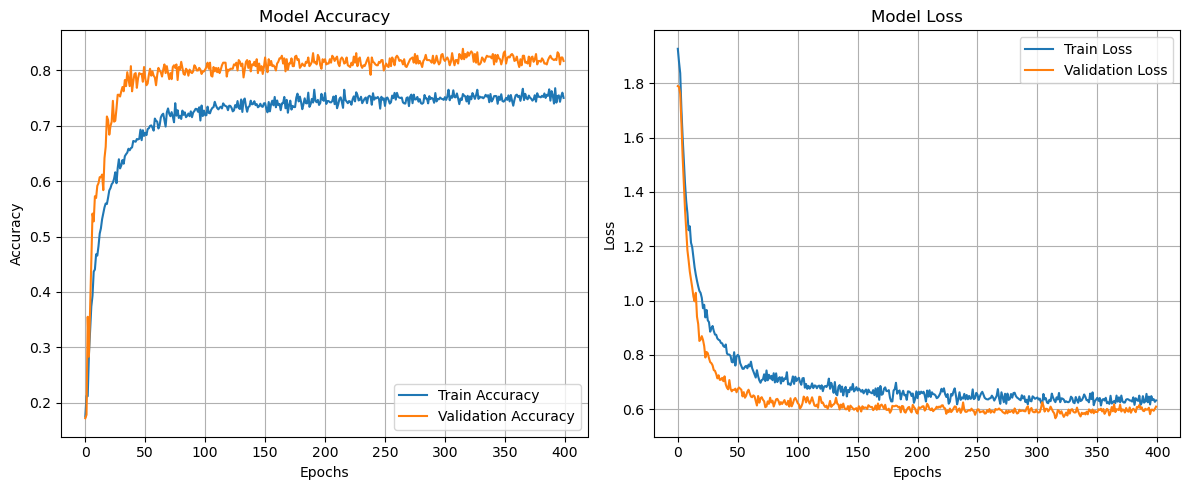

In [12]:
# Plot training history
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(fittedModel.history['accuracy'], label='Train Accuracy')
plt.plot(fittedModel.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(fittedModel.history['loss'], label='Train Loss')
plt.plot(fittedModel.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [13]:
model.load_weights('/tmp/checkpoint.h5')
preds = model.predict(valid_data)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [14]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(np.argmax(valid_label, axis=1), np.argmax(preds, axis=1))

0.8199115865805483

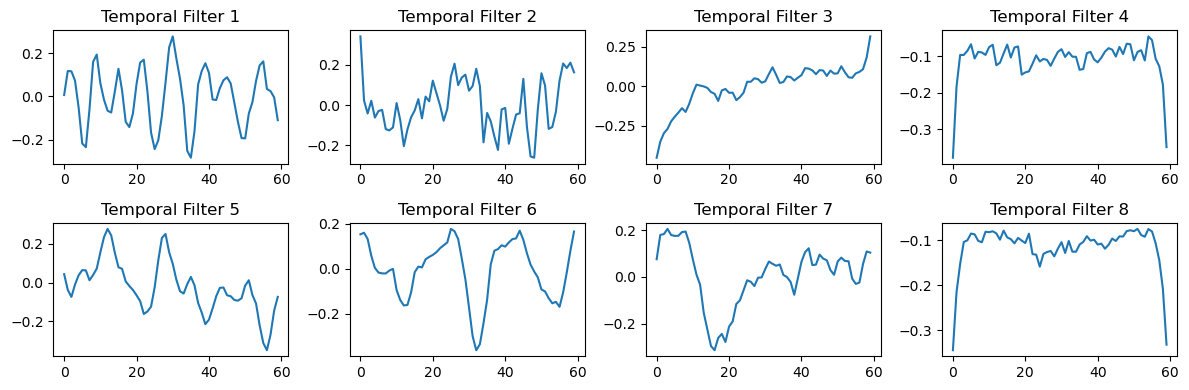

In [15]:
filters = np.squeeze(model.layers[2].get_weights())

fig = plt.subplots(2, 4, figsize=(12, 4))

for i in range(1, 9):
    plt.subplot(2, 4, i)
    plt.plot(filters[:, i-1])
    plt.title(f'Temporal Filter {i}')
    
plt.tight_layout()

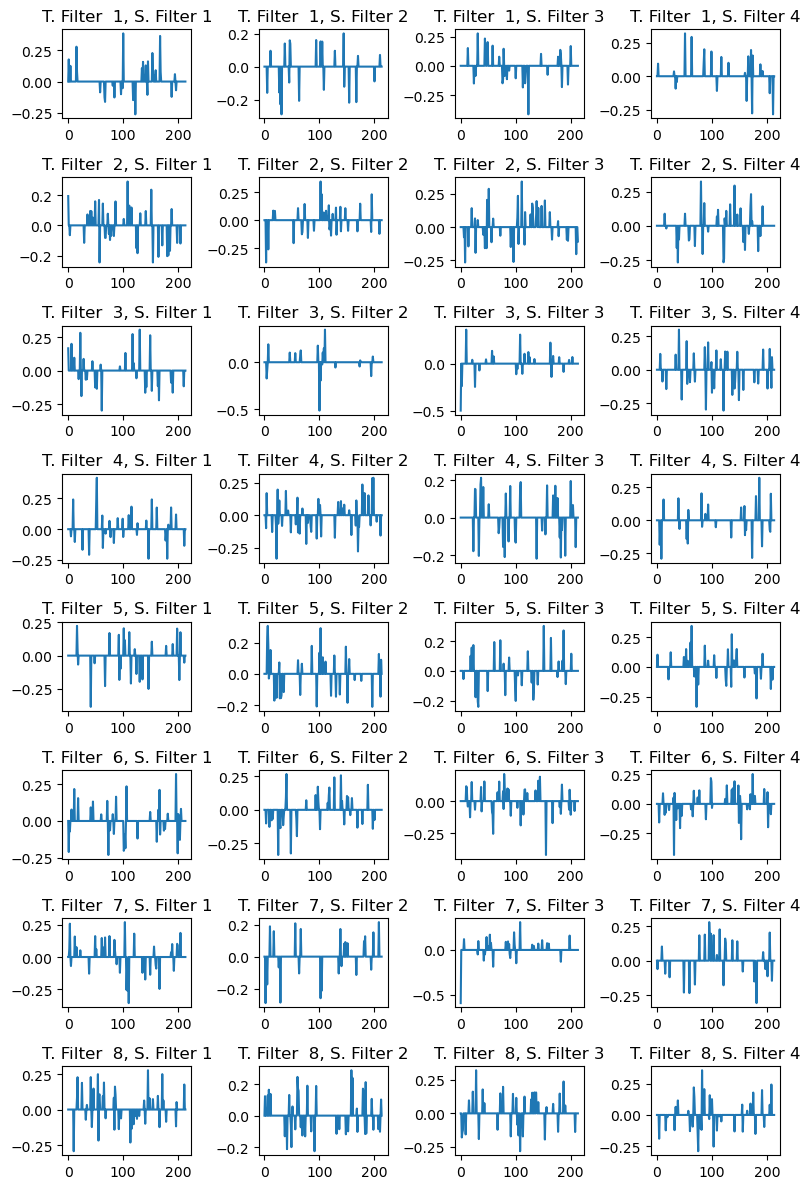

In [16]:
filters = np.squeeze(model.layers[4].get_weights())

fig = plt.subplots(8, 4, figsize=(8, 12))

i = 1
for j in range(8):
    for k in range(4):
        plt.subplot(8, 4, i)
        plt.plot(filters[:, j, k])
        plt.title(f'T. Filter  {j+1}, S. Filter {k+1}')
        i = i + 1
    
plt.tight_layout()